<a href="https://colab.research.google.com/github/Tam107/BDM/blob/evaluation/Good_EE_RF_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Load the new dataset
data = pd.read_excel('new_dataset.xlsx')  # Replace with your actual file name
print("Columns in the dataset:", data.columns.tolist())

# Define column types (adjust based on your XLSX columns)
target = 'price'  # Assuming price is the target
categorical_cols = ['country', 'brand', 'model']  # Example categorical columns
numerical_cols = ['year', 'mileage']  # Example numerical columns

# Data Preprocessing
# Handle missing values
for col in numerical_cols:
    data[col] = data[col].replace([0, np.nan], data[col].median())
for col in categorical_cols:
    data[col] = data[col].fillna('unknown').astype(str)

# Feature engineering: Add mileage per year
if 'year' in data.columns and 'mileage' in data.columns:
    data['mileage_per_year'] = data['mileage'] / (2023 - data['year'] + 1)
    numerical_cols.append('mileage_per_year')

# Filter out invalid prices
data = data[data[target] > 0]

# Clip outliers
for col in numerical_cols + [target]:
    data[col] = data[col].clip(lower=data[col].quantile(0.01), upper=data[col].quantile(0.99))

# Scale features
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
price_scaler = MinMaxScaler()
data[target] = price_scaler.fit_transform(data[[target]])

# Train-Test Split
X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepare data for EE (MLP and EE+RF+MLP)
input_list_train_new = []
input_list_val = []
input_list_test = []
cat_encoders = {}
for col in categorical_cols:
    encoder = {val: idx for idx, val in enumerate(np.unique(X_train_new[col]))}
    cat_encoders[col] = encoder
    input_list_train_new.append(X_train_new[col].map(encoder).fillna(0).values.astype(np.int32))
    input_list_val.append(X_val[col].map(encoder).fillna(0).values.astype(np.int32))
    input_list_test.append(X_test[col].map(encoder).fillna(0).values.astype(np.int32))

input_list_train_new.append(X_train_new[numerical_cols].values.astype(np.float32))
input_list_val.append(X_val[numerical_cols].values.astype(np.float32))
input_list_test.append(X_test[numerical_cols].values.astype(np.float32))

# Prepare data for Random Forest
X_train_rf = pd.get_dummies(X_train_new, columns=categorical_cols)
X_val_rf = pd.get_dummies(X_val, columns=categorical_cols)
X_test_rf = pd.get_dummies(X_test, columns=categorical_cols)
X_train_rf, X_val_rf = X_train_rf.align(X_val_rf, join='left', axis=1, fill_value=0)
X_train_rf, X_test_rf = X_train_rf.align(X_test_rf, join='left', axis=1, fill_value=0)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train_new)
rf_train_preds = rf.predict(X_train_rf).astype(np.float32)
rf_val_preds = rf.predict(X_val_rf).astype(np.float32)
rf_test_preds = rf.predict(X_test_rf).astype(np.float32)

# Define MLP with EE
inputs_mlp = []
embeddings_mlp = []
for col in categorical_cols:
    n_unique = len(cat_encoders[col])
    emb_dim = min(50, (n_unique + 1) // 2)
    inp = Input(shape=(1,), name=f'input_{col}_mlp')
    emb = Embedding(n_unique, emb_dim)(inp)
    emb = Reshape((emb_dim,))(emb)
    inputs_mlp.append(inp)
    embeddings_mlp.append(emb)

num_input_mlp = Input(shape=(len(numerical_cols),), name='input_numeric_mlp')
inputs_mlp.append(num_input_mlp)
embeddings_mlp.append(num_input_mlp)

x = Concatenate()(embeddings_mlp)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
output_mlp = Dense(1, activation='sigmoid')(x)

mlp = Model(inputs=inputs_mlp, outputs=output_mlp)
mlp.compile(optimizer=Adam(learning_rate=0.002), loss='mse', metrics=['mae'])
mlp.fit(input_list_train_new, y_train_new, validation_data=(input_list_val, y_val),
        epochs=150, batch_size=512, callbacks=[EarlyStopping(patience=20, restore_best_weights=True),
                                               ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)], verbose=1)

# Define EE+RF+MLP
inputs_ee_rf_mlp = []
embeddings_ee_rf_mlp = []
for col in categorical_cols:
    n_unique = len(cat_encoders[col])
    emb_dim = min(50, (n_unique + 1) // 2)
    inp = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(n_unique, emb_dim)(inp)
    emb = Reshape((emb_dim,))(emb)
    inputs_ee_rf_mlp.append(inp)
    embeddings_ee_rf_mlp.append(emb)

num_input = Input(shape=(len(numerical_cols),), name='input_numeric')
rf_input = Input(shape=(1,), name='input_rf')
inputs_ee_rf_mlp.extend([num_input, rf_input])
embeddings_ee_rf_mlp.extend([num_input, rf_input])

x = Concatenate()(embeddings_ee_rf_mlp)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
output_ee_rf_mlp = Dense(1, activation='sigmoid')(x)

ee_rf_mlp = Model(inputs=inputs_ee_rf_mlp, outputs=output_ee_rf_mlp)
ee_rf_mlp.compile(optimizer=Adam(learning_rate=0.002), loss='mse', metrics=['mae'])

# Add RF predictions to input lists
input_list_train_new_rf = input_list_train_new + [rf_train_preds]
input_list_val_rf = input_list_val + [rf_val_preds]
input_list_test_rf = input_list_test + [rf_test_preds]

ee_rf_mlp.fit(input_list_train_new_rf, y_train_new, validation_data=(input_list_val_rf, y_val),
              epochs=150, batch_size=512, callbacks=[EarlyStopping(patience=20, restore_best_weights=True),
                                                     ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-5)], verbose=1)

# Predictions
mlp_test_preds = mlp.predict(input_list_test).flatten()
ee_rf_mlp_test_preds = ee_rf_mlp.predict(input_list_test_rf).flatten()

# Inverse transform predictions and actual values
y_test_orig = price_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()
rf_test_preds_orig = price_scaler.inverse_transform(rf_test_preds.reshape(-1, 1)).flatten()
mlp_test_preds_orig = price_scaler.inverse_transform(mlp_test_preds.reshape(-1, 1)).flatten()
ee_rf_mlp_test_preds_orig = price_scaler.inverse_transform(ee_rf_mlp_test_preds.reshape(-1, 1)).flatten()

# Evaluation
print("\nRandom Forest Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, rf_test_preds_orig)):.2f}")
print(f"R2: {r2_score(y_test_orig, rf_test_preds_orig):.2f}")

print("\nMLP with Entity Embedding Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, mlp_test_preds_orig)):.2f}")
print(f"R2: {r2_score(y_test_orig, mlp_test_preds_orig):.2f}")

print("\nEE+RF+MLP Metrics:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_orig, ee_rf_mlp_test_preds_orig)):.2f}")
print(f"R2: {r2_score(y_test_orig, ee_rf_mlp_test_preds_orig):.2f}")

Cell 1: Import libraries

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

print("Libraries imported successfully")

Libraries imported successfully


Cell 2: Dataset - Load Data

In [27]:
# Load the dataset with the original columns
cols_to_keep = [
    'price', 'brand', 'model', 'gearbox', 'kilometer', 'powerPS',
    'yearOfRegistration', 'monthOfRegistration', 'dateCreated',
    'vehicleType', 'fuelType', 'notRepairedDamage'
]
data = pd.read_csv('autos.csv', encoding='latin1', usecols=cols_to_keep)

print("Dataset loaded:")
print(data.head())

Dataset loaded:
   price vehicleType  yearOfRegistration    gearbox  powerPS  model  \
0    480         NaN                1993    manuell        0   golf   
1  18300       coupe                2011    manuell      190    NaN   
2   9800         suv                2004  automatik      163  grand   
3   1500  kleinwagen                2001    manuell       75   golf   
4   3600  kleinwagen                2008    manuell       69  fabia   

   kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
0     150000                    0   benzin  volkswagen               NaN   
1     125000                    5   diesel        audi                ja   
2     125000                    8   diesel        jeep               NaN   
3     150000                    6   benzin  volkswagen              nein   
4      90000                    7   diesel       skoda              nein   

           dateCreated  
0  2016-03-24 00:00:00  
1  2016-03-24 00:00:00  
2  2016-03-14 00:00:00  


Cell 3: Preprocessing - Missing Values, Feature Engineering, Scaling

In [28]:
# Handle missing values
data['powerPS'] = data['powerPS'].replace(0, np.nan).fillna(data['powerPS'].median())
data['yearOfRegistration'] = data['yearOfRegistration'].replace(0, np.nan).fillna(data['yearOfRegistration'].median())
data['monthOfRegistration'] = data['monthOfRegistration'].replace(0, np.nan).fillna(data['monthOfRegistration'].median())
data['gearbox'] = data['gearbox'].fillna('manual')
data['model'] = data['model'].fillna('unknown')
data['brand'] = data['brand'].fillna('unknown')
data['vehicleType'] = data['vehicleType'].fillna('unknown')
data['fuelType'] = data['fuelType'].fillna('unknown')
data['notRepairedDamage'] = data['notRepairedDamage'].fillna('nein')

# Feature engineering
data['dateCreated'] = pd.to_datetime(data['dateCreated'])
data['adYear'] = data['dateCreated'].dt.year
data['car_age'] = data['adYear'] - data['yearOfRegistration']
data['powerPS_per_km'] = data['powerPS'] / (data['kilometer'] + 1)
data['age_km_interaction'] = data['car_age'] * data['kilometer']
data['is_damaged'] = data['notRepairedDamage'].map({'ja': 1, 'nein': 0})
data = data.drop(columns=['dateCreated', 'yearOfRegistration', 'notRepairedDamage'])

# Ensure categorical columns are strings
for col in ['brand', 'model', 'gearbox', 'vehicleType', 'fuelType']:
    data[col] = data[col].astype(str)

# Dummies for gearbox
gearbox_dummies = pd.get_dummies(data['gearbox'], prefix='gearbox')
data = pd.concat([data, gearbox_dummies], axis=1).drop('gearbox', axis=1)

# Numeric columns
numeric_cols = [col for col in data.columns if col not in ['price', 'brand', 'model', 'vehicleType', 'fuelType']]

# Filter price > 0
data = data[data['price'] > 0]
print(f"Number of rows after removing price=0: {len(data)}")

# Clip outliers
for col in ['price', 'kilometer', 'powerPS', 'car_age']:
    lower_bound = data[col].quantile(0.01)
    upper_bound = data[col].quantile(0.99)
    print(f"Clipping {col}: lower_bound={lower_bound}, upper_bound={upper_bound}")
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

# Check for NaN or inf values in numeric columns
print("Checking for NaN or inf values before scaling:")
print(data[numeric_cols].isna().sum())
print(data[numeric_cols].replace([np.inf, -np.inf], np.nan).isna().sum())

# Replace inf with a large finite value and NaN with median
for col in numeric_cols:
    data[col] = data[col].replace([np.inf, -np.inf], np.nan)
    data[col] = data[col].fillna(data[col].median())

# Scale numeric features
scaler = MinMaxScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Scale price
price_scaler = MinMaxScaler()
data['price'] = price_scaler.fit_transform(data[['price']])
print("Price Scaler Parameters:")
print(f"data_min_: {price_scaler.data_min_}")
print(f"data_max_: {price_scaler.data_max_}")

print("\nProcessed data:")
print(data.head())

Number of rows after removing price=0: 360750
Clipping price: lower_bound=110.0, upper_bound=36500.0
Clipping kilometer: lower_bound=5000.0, upper_bound=150000.0
Clipping powerPS: lower_bound=45.0, upper_bound=340.0
Clipping car_age: lower_bound=-2.0, upper_bound=37.0
Checking for NaN or inf values before scaling:
powerPS                0
kilometer              0
monthOfRegistration    0
adYear                 0
car_age                0
powerPS_per_km         0
age_km_interaction     0
is_damaged             0
gearbox_automatik      0
gearbox_manual         0
gearbox_manuell        0
dtype: int64
powerPS                0
kilometer              0
monthOfRegistration    0
adYear                 0
car_age                0
powerPS_per_km         0
age_km_interaction     0
is_damaged             0
gearbox_automatik      0
gearbox_manual         0
gearbox_manuell        0
dtype: int64
Price Scaler Parameters:
data_min_: [110.]
data_max_: [36500.]

Processed data:
      price vehicleType   po

Cell 4: Train-Test Split

In [29]:
# Split data into train, validation, and test sets
X = data.drop(['price'], axis=1).copy()
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f'\nTập huấn luyện có {X_train_new.shape[0]} bản ghi và {X_train_new.shape[1]} cột.')
print(f'Tập validation có {len(X_val)} bản ghi.')
print(f'Tập kiểm tra có {len(X_test)} bản ghi.')


Tập huấn luyện có 230880 bản ghi và 15 cột.
Tập validation có 57720 bản ghi.
Tập kiểm tra có 72150 bản ghi.


Cell 5: Prepare Inputs for RF and MLP with Entity Embedding

In [30]:
# Integer-encode categorical variables for embedding
cat_cols = ['brand', 'model', 'vehicleType', 'fuelType']
cat_encoders = {}
embedded_features = {}
for col in cat_cols:
    unique_vals = X_train_new[col].unique()
    cat_encoders[col] = {val: idx for idx, val in enumerate(unique_vals)}
    X_train_new[col] = X_train_new[col].map(cat_encoders[col]).astype(np.int32)
    X_val[col] = X_val[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    X_test[col] = X_test[col].map(cat_encoders[col]).fillna(0).astype(np.int32)
    n_unique = len(unique_vals)
    # Use original embedding dimensions
    if col == 'brand':
        emb_dim = 8
    elif col == 'model':
        emb_dim = 15
    elif col == 'vehicleType':
        emb_dim = 5
    else:  # fuelType
        emb_dim = 4
    embedded_features[col] = (n_unique, emb_dim)
    print(f'\nCó {n_unique} giá trị duy nhất trong cột {col} trong tập huấn luyện.')

# Numeric features (including gearbox dummies)
num_cols = [col for col in X_train_new.columns if col not in cat_cols]

# Train a neural network to learn embeddings
inputs = []
emb_layers = []
for col in cat_cols:
    n_unique, emb_dim = embedded_features[col]
    inp = Input(shape=(1,), name=f'input_{col}')
    emb = Embedding(input_dim=n_unique, output_dim=emb_dim, name=f'embedding_{col}')(inp)
    emb = Reshape(target_shape=(emb_dim,))(emb)
    inputs.append(inp)
    emb_layers.append(emb)

inp_num = Input(shape=(len(num_cols),), name='input_num')
inputs.append(inp_num)

x = Concatenate()(emb_layers + [inp_num])
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)

embedding_model = Model(inputs=inputs, outputs=output)
embedding_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Prepare inputs for training embeddings
train_inputs = [X_train_new[col].values for col in cat_cols] + [X_train_new[num_cols].values]
val_inputs = [X_val[col].values for col in cat_cols] + [X_val[num_cols].values]
test_inputs = [X_test[col].values for col in cat_cols] + [X_test[num_cols].values]

# Train the model to learn embeddings
embedding_model.fit(train_inputs, y_train_new, validation_data=(val_inputs, y_val), epochs=10, batch_size=512, verbose=1)

# Extract embeddings
embedding_dict = {}
for col in cat_cols:
    emb_layer = embedding_model.get_layer(f'embedding_{col}')
    embedding_dict[col] = emb_layer.get_weights()[0]

# Transform categorical features into embedded vectors
X_train_embedded = []
X_val_embedded = []
X_test_embedded = []
for col in cat_cols:
    emb_matrix = embedding_dict[col]
    train_emb = emb_matrix[X_train_new[col].values]
    val_emb = emb_matrix[X_val[col].values]
    test_emb = emb_matrix[X_test[col].values]
    X_train_embedded.append(train_emb)
    X_val_embedded.append(val_emb)
    X_test_embedded.append(test_emb)

# Concatenate with numeric features
X_train_embedded = np.hstack(X_train_embedded + [X_train_new[num_cols].values])
X_val_embedded = np.hstack(X_val_embedded + [X_val[num_cols].values])
X_test_embedded = np.hstack(X_test_embedded + [X_test[num_cols].values])

# Convert target variables to float32
y_train_new = y_train_new.values.astype(np.float32)
y_val = y_val.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

print("Shape of embedded training data:", X_train_embedded.shape)
print("Shape of embedded validation data:", X_val_embedded.shape)
print("Shape of embedded test data:", X_test_embedded.shape)


Có 40 giá trị duy nhất trong cột brand trong tập huấn luyện.

Có 250 giá trị duy nhất trong cột model trong tập huấn luyện.

Có 9 giá trị duy nhất trong cột vehicleType trong tập huấn luyện.

Có 8 giá trị duy nhất trong cột fuelType trong tập huấn luyện.
Epoch 1/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0404 - val_loss: 0.0080
Epoch 2/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0073 - val_loss: 0.0067
Epoch 3/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 4/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 5/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0053 - val_loss: 0.0054
Epoch 6/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 7/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0050 - val_loss: 0.0051
Epoch 8/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/10
451/451 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - l

Cell 6: Prepare Data for Hybrid Model (Adjusted)

In [31]:
# Prepare inputs for hybrid model
input_list_train_new = [X_train_embedded]
input_list_val = [X_val_embedded]
input_list_test = [X_test_embedded]

print("Hybrid model input shape (training, embedded features):", input_list_train_new[0].shape)

Hybrid model input shape (training, embedded features): (230880, 43)


Cell 7: Random Forest - Train with Entity Embedding Output

In [32]:
# Train Random Forest on embedded data
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_embedded, y_train_new)

# Generate RF predictions
rf_train_preds = rf.predict(X_train_embedded).astype(np.float32)
rf_val_preds = rf.predict(X_val_embedded).astype(np.float32)
rf_test_preds = rf.predict(X_test_embedded).astype(np.float32)

print("Random Forest training completed.")
print("Sample RF predictions (test):", rf_test_preds[:5])

Random Forest training completed.
Sample RF predictions (test): [0.22788635 0.10720742 0.36849236 0.39846775 0.02345902]


Cell 8: Hybrid EE+RF+MLP Model (Adjusted)


Epoch 1/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 0.3946 - mae: 0.0601 - val_loss: 0.0385 - val_mae: 0.1587 - learning_rate: 0.0020
Epoch 2/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0043 - mae: 0.0345 - val_loss: 0.0087 - val_mae: 0.0521 - learning_rate: 0.0020
Epoch 3/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0034 - mae: 0.0318 - val_loss: 0.0086 - val_mae: 0.0500 - learning_rate: 0.0020
Epoch 4/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0034 - mae: 0.0322 - val_loss: 0.0058 - val_mae: 0.0411 - learning_rate: 0.0020
Epoch 5/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0033 - mae: 0.0319 - val_loss: 0.0050 - val_mae: 0.0367 - learning_rate: 0.0020
Epoch 6/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0033 - mae: 0.0320 - val_loss: 0.0084 - val_mae: 0.0478 - learning_rate: 0.0020
Epoch 7/150
451/451 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0034 - mae: 0.0322 - val_loss: 0.0070 - val_mae: 0.0583 - learning_r

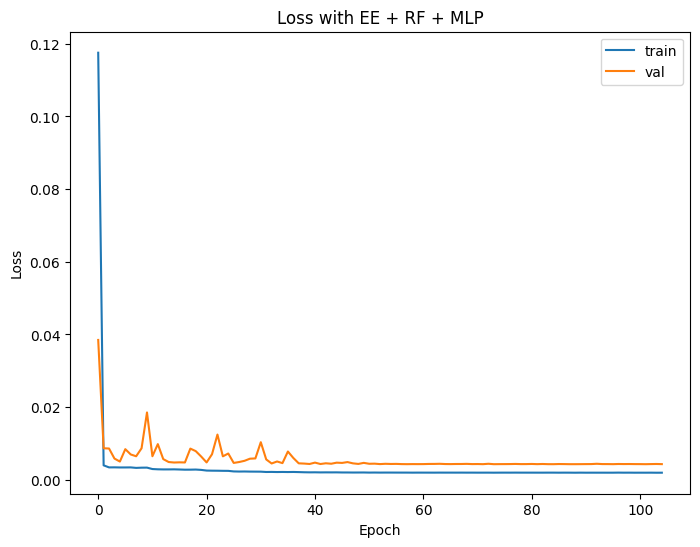

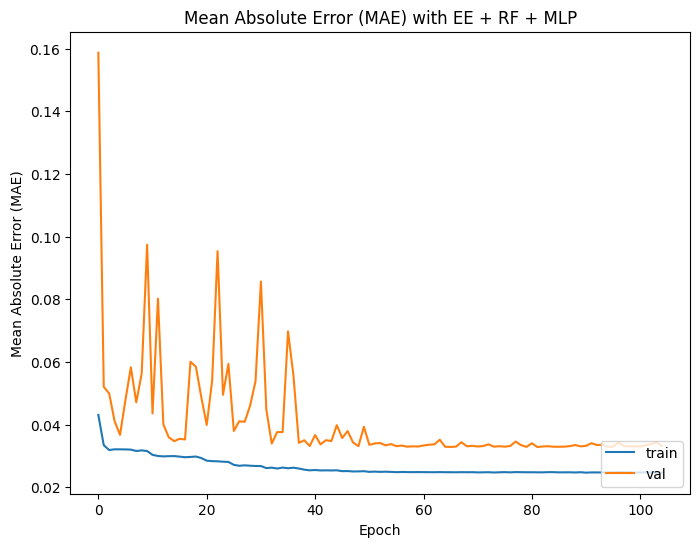

In [33]:
# Define hybrid EE+RF+MLP using the same embedded input
input_brand = Input(shape=(1,), name='input_brand')
emb_brand = Embedding(input_dim=embedded_features['brand'][0], output_dim=8)(input_brand)
emb_brand = Reshape(target_shape=(8,))(emb_brand)

input_model = Input(shape=(1,), name='input_model')
emb_model = Embedding(input_dim=embedded_features['model'][0], output_dim=15)(input_model)
emb_model = Reshape(target_shape=(15,))(emb_model)

input_vehicleType = Input(shape=(1,), name='input_vehicleType')
emb_vehicleType = Embedding(input_dim=embedded_features['vehicleType'][0], output_dim=5)(input_vehicleType)
emb_vehicleType = Reshape(target_shape=(5,))(emb_vehicleType)

input_fuelType = Input(shape=(1,), name='input_fuelType')
emb_fuelType = Embedding(input_dim=embedded_features['fuelType'][0], output_dim=4)(input_fuelType)
emb_fuelType = Reshape(target_shape=(4,))(emb_fuelType)

input_numeric = Input(shape=(len(num_cols),), name='input_numeric')
input_rf = Input(shape=(1,), name='input_rf')

input_data = [input_brand, input_model, input_vehicleType, input_fuelType, input_numeric, input_rf]
emb_data = [emb_brand, emb_model, emb_vehicleType, emb_fuelType, input_numeric, input_rf]

model_data = Concatenate()(emb_data)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.005))(model_data)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(x)
x = BatchNormalization()(x)
x = Dense(32, activation='relu', kernel_regularizer=l2(0.005))(x)
outputs = Dense(1, activation='sigmoid')(x)

ee_rf_mlp = Model(inputs=input_data, outputs=outputs, name='EE_RF_MLP')
ee_rf_mlp.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.002), metrics=['mae'])

# Prepare inputs with RF predictions
input_list_train_new_rf = [X_train_new['brand'].values, X_train_new['model'].values, X_train_new['vehicleType'].values, X_train_new['fuelType'].values, X_train_new[num_cols].values, rf_train_preds.reshape(-1, 1)]
input_list_val_rf = [X_val['brand'].values, X_val['model'].values, X_val['vehicleType'].values, X_val['fuelType'].values, X_val[num_cols].values, rf_val_preds.reshape(-1, 1)]
input_list_test_rf = [X_test['brand'].values, X_test['model'].values, X_test['vehicleType'].values, X_test['fuelType'].values, X_test[num_cols].values, rf_test_preds.reshape(-1, 1)]

# Train the hybrid model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-05)

history_ee_rf_mlp = ee_rf_mlp.fit(
    input_list_train_new_rf,
    y_train_new,
    validation_data=(input_list_val_rf, y_val),
    epochs=150,
    batch_size=512,
    verbose=1,
    callbacks=[es, lr_scheduler]
)

# Generate predictions
ee_rf_mlp_preds = ee_rf_mlp.predict(input_list_test_rf).flatten()

# Plot training history
plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['loss'], label='Training Loss')
plt.plot(history_ee_rf_mlp.history['val_loss'], label='Validation Loss')
plt.title('Loss with EE + RF + MLP')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history_ee_rf_mlp.history['mae'], label='Training MAE')
plt.plot(history_ee_rf_mlp.history['val_mae'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE) with EE + RF + MLP')
plt.ylabel('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

Cell 9: Evaluation

Evaluation Metrics for EE+RF+MLP:
        EE_RF_MLP
MSE     4986323.0
RMSE  2233.007613
R2       0.893256
MAPE    36.327152


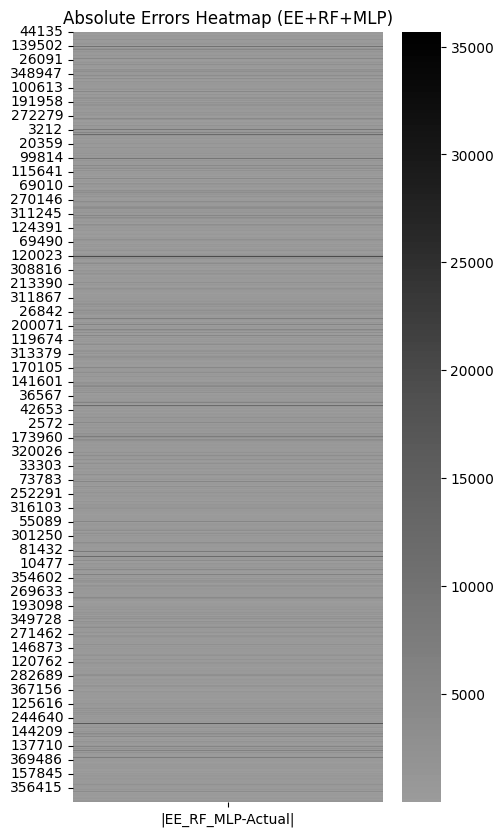

In [36]:
# Inverse transform predictions and actual values
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(ee_rf_mlp_preds.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100
    return mse, rmse, r2, mape

# Calculate metrics for hybrid model
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=['EE_RF_MLP'])
mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df['EE_RF_MLP'])
metric_df.at['MSE', 'EE_RF_MLP'] = mse
metric_df.at['RMSE', 'EE_RF_MLP'] = rmse
metric_df.at['R2', 'EE_RF_MLP'] = r2
metric_df.at['MAPE', 'EE_RF_MLP'] = mape

print("Evaluation Metrics for EE+RF+MLP:")
print(metric_df)

# Heatmap of absolute errors
result_df['|EE_RF_MLP-Actual|'] = np.abs(result_df['EE_RF_MLP'] - result_df['Actual'])
table = result_df[['|EE_RF_MLP-Actual|']]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap (EE+RF+MLP)')
plt.show()

Cell 10: Evaluation with Enhanced Visualizations

Problem with lower car price



Evaluation Metrics for EE+RF+MLP:
        EE_RF_MLP
MSE     4986323.0
RMSE  2233.007613
R2       0.893256
MAPE    36.327152

Sample Prediction Results ( Samples):
           EE_RF_MLP        Actual   Difference
44135    8481.383789   8299.000000  -182.383789
64221    4053.819092   6498.999512  2445.180420
223484  13284.675781  12950.000000  -334.675781


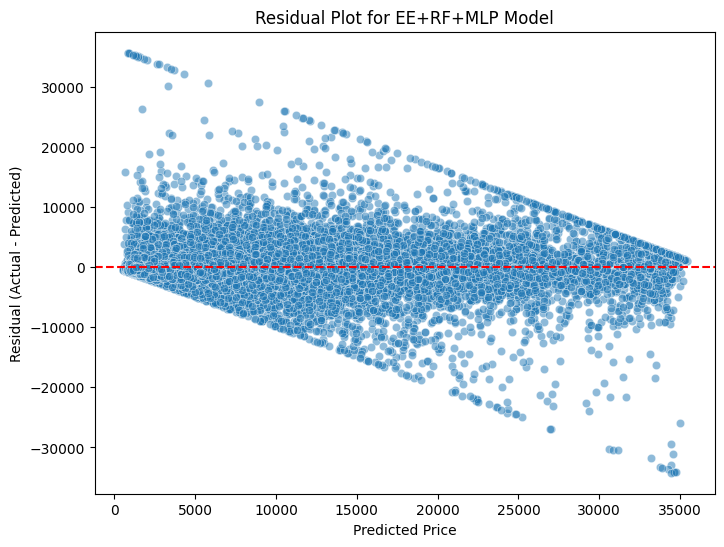

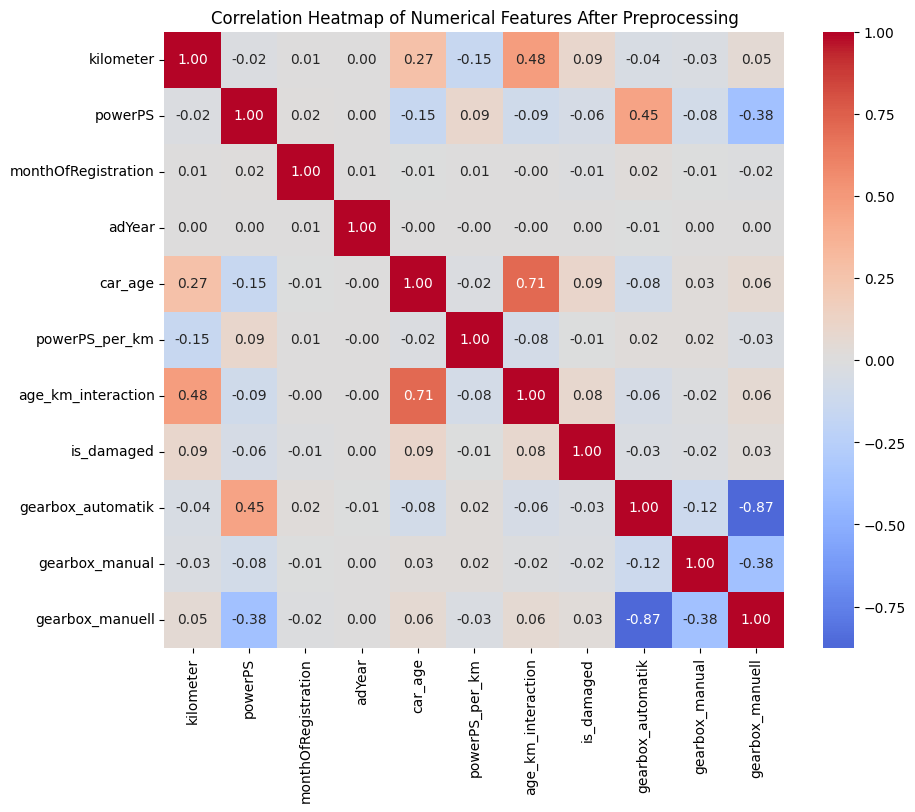


Summary of Embedded Categorical Features:
brand: 40 unique values, embedded into 8 dimensions
model: 250 unique values, embedded into 15 dimensions
vehicleType: 9 unique values, embedded into 5 dimensions
fuelType: 8 unique values, embedded into 4 dimensions


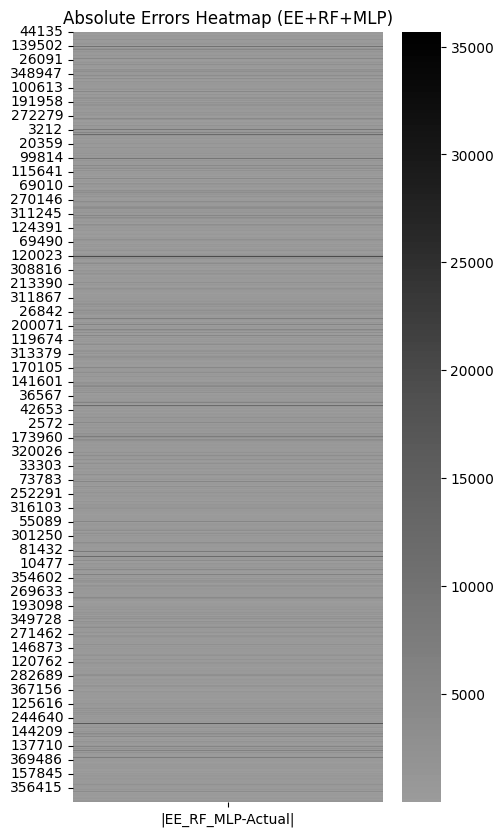

In [39]:
# Inverse transform predictions and actual values
y_test_predict_ee_rf_mlp = price_scaler.inverse_transform(ee_rf_mlp_preds.reshape(-1, 1)).flatten()
y_test_original = price_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Create results DataFrame
result_df = pd.DataFrame(index=X_test.index, columns=['EE_RF_MLP', 'Actual'])
result_df['Actual'] = y_test_original
result_df['EE_RF_MLP'] = y_test_predict_ee_rf_mlp

# Define metric calculation function
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1000))) * 100
    return mse, rmse, r2, mape

# Calculate metrics for hybrid model
metric_df = pd.DataFrame(index=['MSE', 'RMSE', 'R2', 'MAPE'], columns=['EE_RF_MLP'])
mse, rmse, r2, mape = calculate_metrics(result_df['Actual'], result_df['EE_RF_MLP'])
metric_df.at['MSE', 'EE_RF_MLP'] = mse
metric_df.at['RMSE', 'EE_RF_MLP'] = rmse
metric_df.at['R2', 'EE_RF_MLP'] = r2
metric_df.at['MAPE', 'EE_RF_MLP'] = mape

print("Evaluation Metrics for EE+RF+MLP:")
print(metric_df)

# 1. Show more prediction results: Sample of actual vs. predicted prices
print("\nSample Prediction Results ( Samples):")
sample_results = result_df.head(3).copy()
sample_results['Difference'] = sample_results['Actual'] - sample_results['EE_RF_MLP']
print(sample_results)

# 2. Residual Plot: Actual - Predicted vs. Predicted
result_df['Residual'] = result_df['Actual'] - result_df['EE_RF_MLP']
plt.figure(figsize=(8, 6))
sns.scatterplot(x=result_df['EE_RF_MLP'], y=result_df['Residual'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot for EE+RF+MLP Model')
plt.show()

# 3. Heatmap After Preprocessing
# Numerical features correlation matrix
num_cols = ['kilometer', 'powerPS', 'monthOfRegistration', 'adYear', 'car_age',
            'powerPS_per_km', 'age_km_interaction', 'is_damaged',
            'gearbox_automatik', 'gearbox_manual', 'gearbox_manuell']
num_data = X_test[num_cols]
corr_matrix = num_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Heatmap of Numerical Features After Preprocessing')
plt.show()

# Summary of embedded categorical features
print("\nSummary of Embedded Categorical Features:")
for col in ['brand', 'model', 'vehicleType', 'fuelType']:
    n_unique, emb_dim = embedded_features[col]
    print(f"{col}: {n_unique} unique values, embedded into {emb_dim} dimensions")

# Heatmap of absolute errors (existing)
result_df['|EE_RF_MLP-Actual|'] = np.abs(result_df['EE_RF_MLP'] - result_df['Actual'])
table = result_df[['|EE_RF_MLP-Actual|']]
plt.figure(figsize=(5, 10))
sns.heatmap(table, center=table.mean().mean(), cmap="Greys")
plt.title('Absolute Errors Heatmap (EE+RF+MLP)')
plt.show()